In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')


In [6]:
df_raw = pd.read_excel('Toimitukset.xlsx', skiprows=16)

In [7]:
df_raw = df_raw.loc[:,~df_raw.columns.str.contains('vko', case=False)].drop(columns=['Nimikkeen status', 'Yks'])

In [8]:
df_raw.head(2)

,Nimike,Nimikkeen kuvaus,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,...,2021-35,2021-36,2021-37,2021-38,2021-39,2021-40,2021-41,2021-42,2021-43,2021-44
0,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,68.0,78.0,89.0,77.0,53.0,112.0,113.0,132.0,...,104.0,157.0,103.0,162.0,171.0,116.0,70.0,83.0,124.0,91
1,Z290468,TUTKIMUSKÄSINE NITRIILI PITKÄ KOKO M;ABENA CLA...,496.0,678.0,646.0,616.0,835.0,552.0,1111.0,1534.0,...,613.0,826.0,598.0,618.0,874.0,824.0,671.0,744.0,839.0,919


### Unpivot 

In [9]:
df_unpivot = df_raw.melt(id_vars=['Nimike', 'Nimikkeen kuvaus'], var_name='Viikko', value_name='Tilaukset')

In [10]:
df_unpivot.head(2)

,Nimike,Nimikkeen kuvaus,Viikko,Tilaukset
0,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-05,68.0
1,Z290468,TUTKIMUSKÄSINE NITRIILI PITKÄ KOKO M;ABENA CLA...,2020-05,496.0


### Lisätään 12 kk rivien määrä sekä nimikkeen tyyppi

In [11]:
df_rivit = pd.read_excel('Toimitusvoluumi_yhteenveto.xlsx', usecols=['Nimike', 'Nimikkeen tyyppi', '12kk rivien lkm'])

In [12]:
df_rivit.head()

,Nimike,Nimikkeen tyyppi,12kk rivien lkm
0,Z000150,Kauttakulku,2
1,Z000251001,Kauttakulku,2
2,Z000251002,Kauttakulku,3
3,Z000251003,Kauttakulku,2
4,Z000251004,Kauttakulku,3


In [13]:
df_final = df_unpivot.merge(df_rivit, how='inner', on='Nimike' )

In [14]:
df_final.head()

,Nimike,Nimikkeen kuvaus,Viikko,Tilaukset,Nimikkeen tyyppi,12kk rivien lkm
0,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-05,68.0,Varasto,1037
1,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-06,78.0,Varasto,1037
2,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-07,89.0,Varasto,1037
3,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-08,77.0,Varasto,1037
4,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-09,53.0,Varasto,1037


### Data cleanup

In [15]:
df_final.isna().sum()

Nimike                   0
Nimikkeen kuvaus     48639
Viikko                   0
Tilaukset           186315
Nimikkeen tyyppi        93
12kk rivien lkm          0
dtype: int64

In [16]:
df_final.fillna(value = {'Tilaukset':0}, inplace=True)

In [17]:
df_final.dropna(subset=['Nimikkeen tyyppi'], inplace=True)

In [18]:
df_final = df_final[df_final['Nimikkeen tyyppi'] == 'Varasto']

In [19]:
df_final.head(2)

,Nimike,Nimikkeen kuvaus,Viikko,Tilaukset,Nimikkeen tyyppi,12kk rivien lkm
0,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-05,68.0,Varasto,1037
1,ZMMT7020C2,GLUKOOSISEURANNAN ERILLISJÄRJESTELMÄ;GUARDIAN ...,2020-06,78.0,Varasto,1037


### Näytä satunnainen tuote ja sen MIN-parametrin muutos ajan suhteen

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
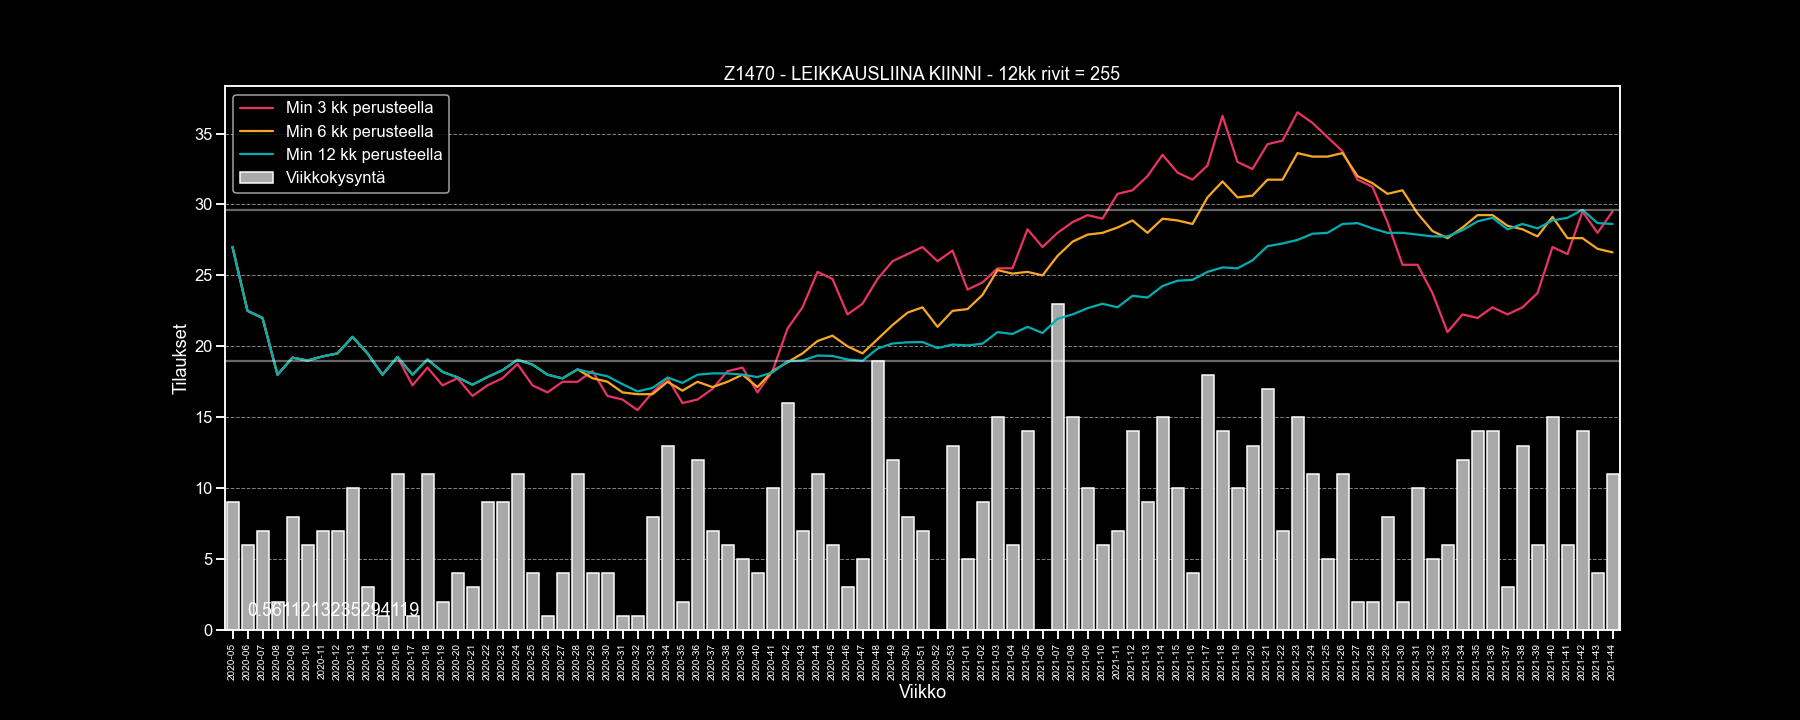

In [55]:

rand = np.random.choice(df_final['Nimike'].unique())
#rand = 'ZMR290'
#rand = 'ZHTT069'
#rand = 'ZHTT399'
#rand = 'Z504605X'
#rand = 'Z344860'
#rand = 'Z472246'
#rand = 'ZMMT7020C2'
#rand = 'ZHK9161406V'
#rand ='ZHTT344'
df_rand = df_final[df_final['Nimike'] == rand]

df_rand['MIN_last_3_months'] = df_rand['Tilaukset'].rolling(window=3*4,min_periods=1).mean() * 3
df_rand['MIN_last_6_months'] = df_rand['Tilaukset'].rolling(window=6*4,min_periods=1).mean() * 3
df_rand['MIN_last_12_months'] = df_rand['Tilaukset'].rolling(window=12*4,min_periods=1).mean() * 3


lowest_last_12_moths = df_rand['MIN_last_12_months'].tail(52).min()
highest_last_12_moths = df_rand['MIN_last_12_months'].tail(52).max()

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(x='Viikko', y='MIN_last_3_months', data=df_rand, label='Min 3 kk perusteella', color='#e83363')
sns.lineplot(x='Viikko', y='MIN_last_6_months', data=df_rand, label='Min 6 kk perusteella', color='#f7a823')
sns.lineplot(x='Viikko', y='MIN_last_12_months', data=df_rand, label='Min 12 kk perusteella', color='#00adb1')

sns.barplot(x='Viikko', y='Tilaukset', data=df_rand, label='Viikkokysyntä', color='#A9A9A9')

ax.axhline(lowest_last_12_moths, alpha=0.4)
ax.axhline(highest_last_12_moths, alpha=0.4)

plt.text(1,1, str((highest_last_12_moths / lowest_last_12_moths)-1))

ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=1)

ax.legend()
ax.set_title(str(df_rand['Nimike'].iloc[0]) + ' - ' + str(df_rand['Nimikkeen kuvaus'].iloc[0])[0:20] +' - 12kk rivit = ' + str(df_rand['12kk rivien lkm'].iloc[0]))
plt.xticks(rotation=90, fontsize=10);

### Suhteellinen vaihteluväli edellisen vuoden aikana 

In [51]:
df_deviations = pd.DataFrame(columns=['Nimike', 'max_deviation'])
nimikkeet = df_final['Nimike'].unique()

for nimike in nimikkeet:
    
    df_temp = df_final[df_final['Nimike'] == nimike]

    df_temp['MIN_last_12_months'] = df_temp['Tilaukset'].rolling(window=12*4,min_periods=1).mean() * 3
    
    lowest_last_12_moths = df_temp['MIN_last_12_months'].tail(52).min()
    highest_last_12_moths = df_temp['MIN_last_12_months'].tail(52).max()
    
    
    deviations = []
           
    deviations.append(nimike)
    try:
        deviations.append(abs(highest_last_12_moths / lowest_last_12_moths) -1)
        
        df_length = len(df_deviations)
        df_deviations.loc[df_length] = deviations
        
    except Exception:
        pass


In [53]:
df_deviations.head()

,Nimike,max_deviation
0,ZMMT7020C2,0.355004
1,Z290468,0.934482
2,Z15271/,0.033954
3,Z287410/,0.166071
4,Z3215,0.142730


### MIN arvon vaihtelu vuoden aikana - kokonaiskuva

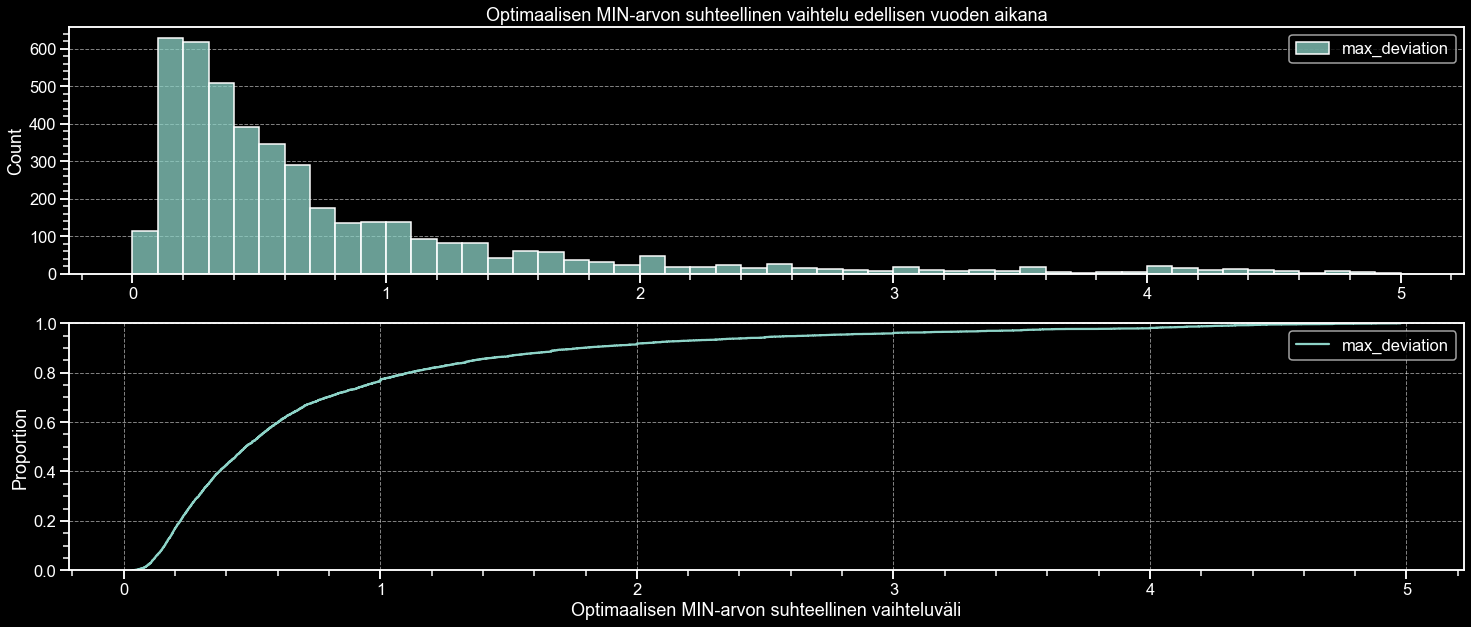

In [84]:
fig, axes = plt.subplots(2,1,figsize=(25,10))

sns.histplot(df_deviations[df_deviations['max_deviation'] < 5], binwidth=0.1, binrange=(0,5), ax=axes[0])

sns.ecdfplot(df_deviations[df_deviations['max_deviation'] < 5], ax=axes[1])
axes[0].set_title('Optimaalisen MIN-arvon suhteellinen vaihtelu edellisen vuoden aikana')
axes[1].set_xlabel('Optimaalisen MIN-arvon suhteellinen vaihteluväli')

axes[0].minorticks_on()
axes[1].minorticks_on()

axes[0].grid(axis='y', linestyle='--', alpha=0.5, linewidth=1)
axes[1].grid(linestyle='--', alpha=0.5, linewidth=1)

### Standardipoikkeamat tuotteille 3 kk, 6 kk, 12 kk

In [17]:
df_standev = pd.DataFrame(columns=['Nimike', 'CV_MIN_last_3_months', 'CV_MIN_last_6_months', 'CV_MIN_last_12_months'])

In [18]:
nimikkeet = df_final['Nimike'].unique()

In [ ]:

for nimike in nimikkeet:
  
    df_temp = df_final[df_final['Nimike'] == nimike]
    df_temp['MIN_last_3_months'] = df_temp['Tilaukset'].rolling(window=3*4,min_periods=1).mean() * 3
    df_temp['MIN_last_6_months'] = df_temp['Tilaukset'].rolling(window=6*4,min_periods=1).mean() * 3
    df_temp['MIN_last_12_months'] = df_temp['Tilaukset'].rolling(window=12*4,min_periods=1).mean() * 3

    df_temp = df_temp.tail(52)

    CVs = []
    
    
    
    CVs.append(nimike)
    try:
        CVs.append(df_temp['MIN_last_3_months'].std(axis=0) / df_temp['MIN_last_3_months'].mean(axis=0))
        CVs.append(df_temp['MIN_last_6_months'].std(axis=0) / df_temp['MIN_last_6_months'].mean(axis=0))
        CVs.append(df_temp['MIN_last_12_months'].std(axis=0) / df_temp['MIN_last_12_months'].mean(axis=0))
        
        df_length = len(df_standev)
        df_standev.loc[df_length] = CVs
        
    except Exception:
        pass

    

In [20]:
df_standev

,Nimike,CV_MIN_last_3_months,CV_MIN_last_6_months,CV_MIN_last_12_months
0,ZMMT7020C2,0.112977,0.119958,0.102098
1,Z290468,0.444286,0.323556,0.204856
2,Z15271/,0.033983,0.021068,0.006595
3,Z287410/,0.253627,0.168109,0.045028
4,Z3215,0.195877,0.089093,0.035534
...,...,...,...,...
5164,ZHK4439635/,3.497899,3.497899,3.497899
5165,ZYT5,3.179302,3.179302,3.179302
5166,Z67102914,4.397301,4.397301,4.397301
5167,Z66801274/1,3.840503,3.840503,3.840503


In [21]:
df_scatter = df_standev.merge(df_rivit[['Nimike', '12kk rivien lkm']], how='left', on='Nimike' )

In [22]:
df_scatter.head()

,Nimike,CV_MIN_last_3_months,CV_MIN_last_6_months,CV_MIN_last_12_months,12kk rivien lkm
0,ZMMT7020C2,0.112977,0.119958,0.102098,1037
1,Z290468,0.444286,0.323556,0.204856,2331
2,Z15271/,0.033983,0.021068,0.006595,1821
3,Z287410/,0.253627,0.168109,0.045028,286
4,Z3215,0.195877,0.089093,0.035534,251


(-258.6, 3000.0)

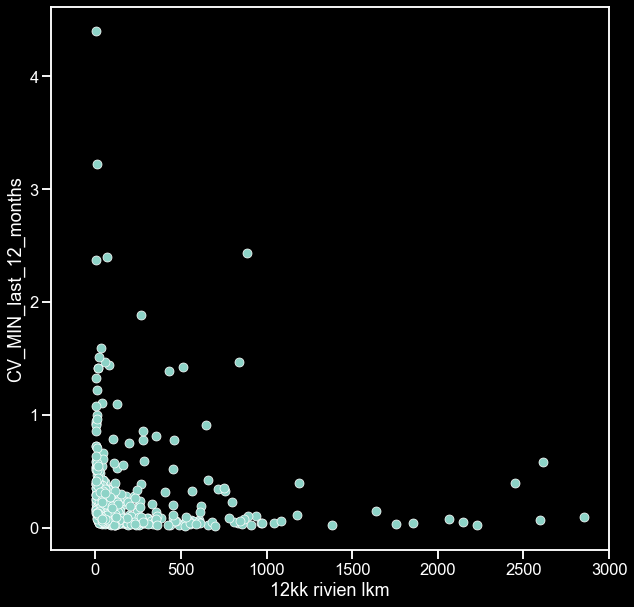

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='12kk rivien lkm', y='CV_MIN_last_12_months', data=df_scatter.sample(500), ax=ax)
ax.set_xlim(right = 3000)

### Suhteellinen vaihtelu suhteessa tilausrivien määrään

No handles with labels found to put in legend.


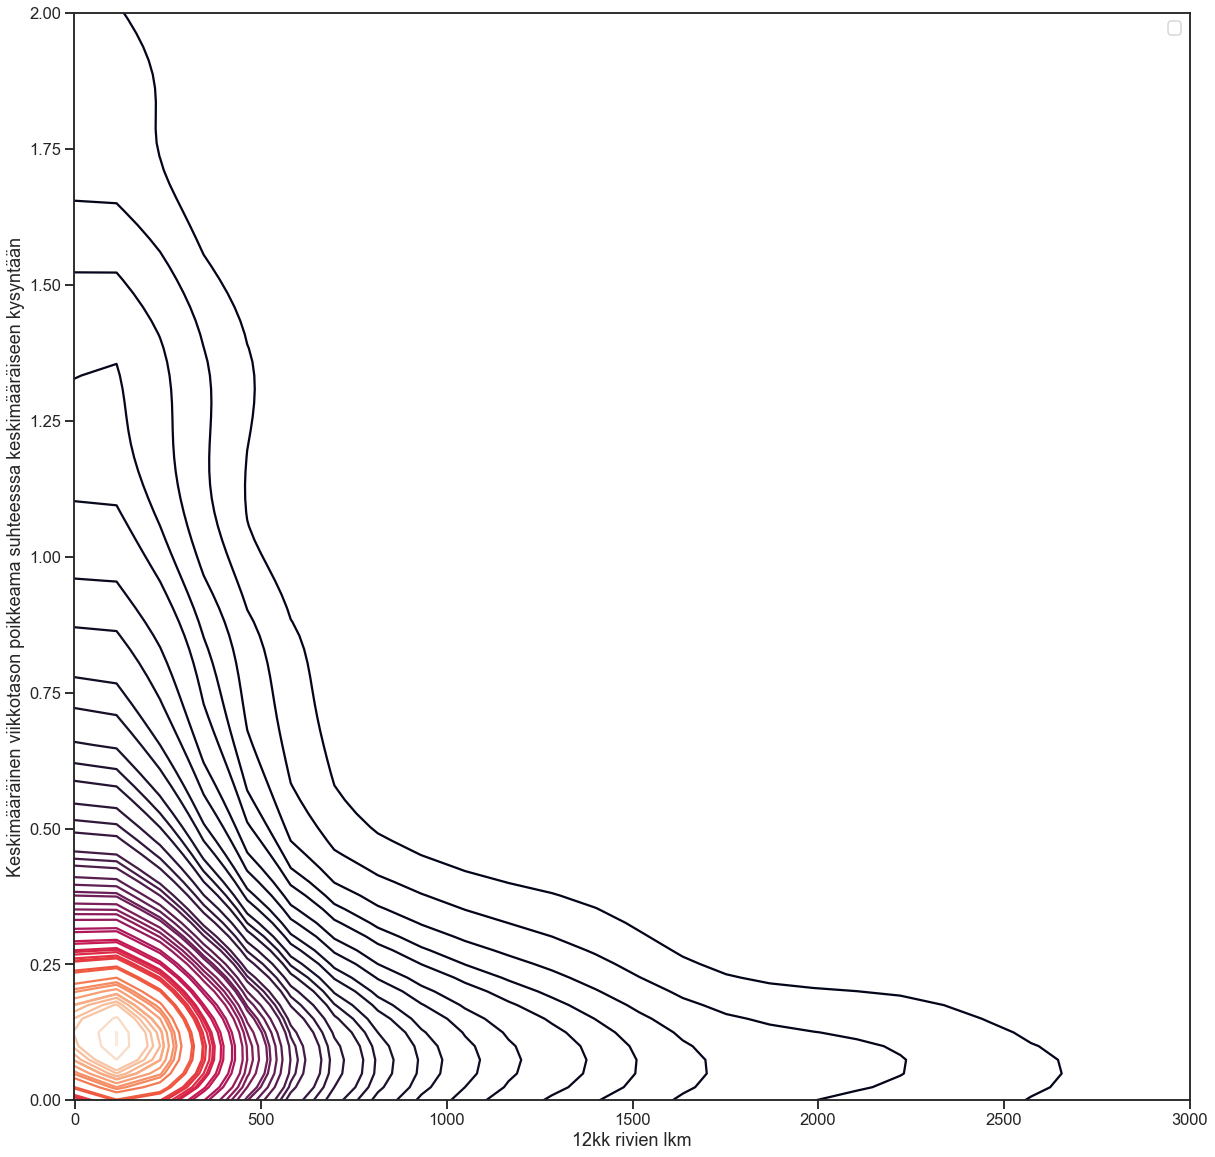

In [24]:
sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(20,20))

sns.kdeplot(x='12kk rivien lkm', y='CV_MIN_last_12_months', data=df_scatter, levels = 50, fill=False, cmap='rocket')
ax.set_xlim(-5,3000)
ax.set_ylim(0,2)
ax.set_ylabel('Keskimääräinen viikkotason poikkeama suhteesssa keskimääräiseen kysyntään')
ax.legend()

### Jälkitoimitukset

In [26]:
df_jälki_raw = pd.read_excel('Jälkitoimitukset.xlsx', skiprows=2, usecols=['Nimike', 'Toimittamaton määrä','Jälkitoimituksen aikaleima'])

In [27]:
df_jälki_raw.head()

,Nimike,Toimittamaton määrä,Jälkitoimituksen aikaleima
0,ZSOFT11,3.0,2021-03-30 09:16
1,Z200110A,6.0,2021-04-08 03:17
2,Z07671687170,3.0,2021-03-29 09:12
3,Z15767224,4.0,2021-03-30 03:14
4,Z47554,1.0,2021-04-07 07:10


In [28]:
df_jälki = df_jälki_raw.groupby(by='Nimike')['Toimittamaton määrä'].agg(['sum', 'count'])

In [29]:
df_jälki.rename(columns={'sum':'Jälkitoimitus kpl', 'count':'Jälkitoimitusrivit'}, inplace=True)

In [30]:
df_jälki.head()

,Jälkitoimitus kpl,Jälkitoimitusrivit
Nimike,,
Z000251002,2.0,1
Z000251004,1.0,1
Z000251005,1.0,1
Z000251006,15.0,6
Z000312000,1.0,1


In [31]:
df_scatter_jälki = pd.merge(df_scatter, df_jälki, on='Nimike', how='left')

In [32]:
df_scatter_jälki.head()

,Nimike,CV_MIN_last_3_months,CV_MIN_last_6_months,CV_MIN_last_12_months,12kk rivien lkm,Jälkitoimitus kpl,Jälkitoimitusrivit
0,ZMMT7020C2,0.112977,0.119958,0.102098,1037,42.0,9.0
1,Z290468,0.444286,0.323556,0.204856,2331,3071.0,202.0
2,Z15271/,0.033983,0.021068,0.006595,1821,NaN,NaN
3,Z287410/,0.253627,0.168109,0.045028,286,NaN,NaN
4,Z3215,0.195877,0.089093,0.035534,251,3.0,2.0


### Jälkitoimitusten, tilausriven ja kysynnän vaihtelun suhde

(0.0, 100.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
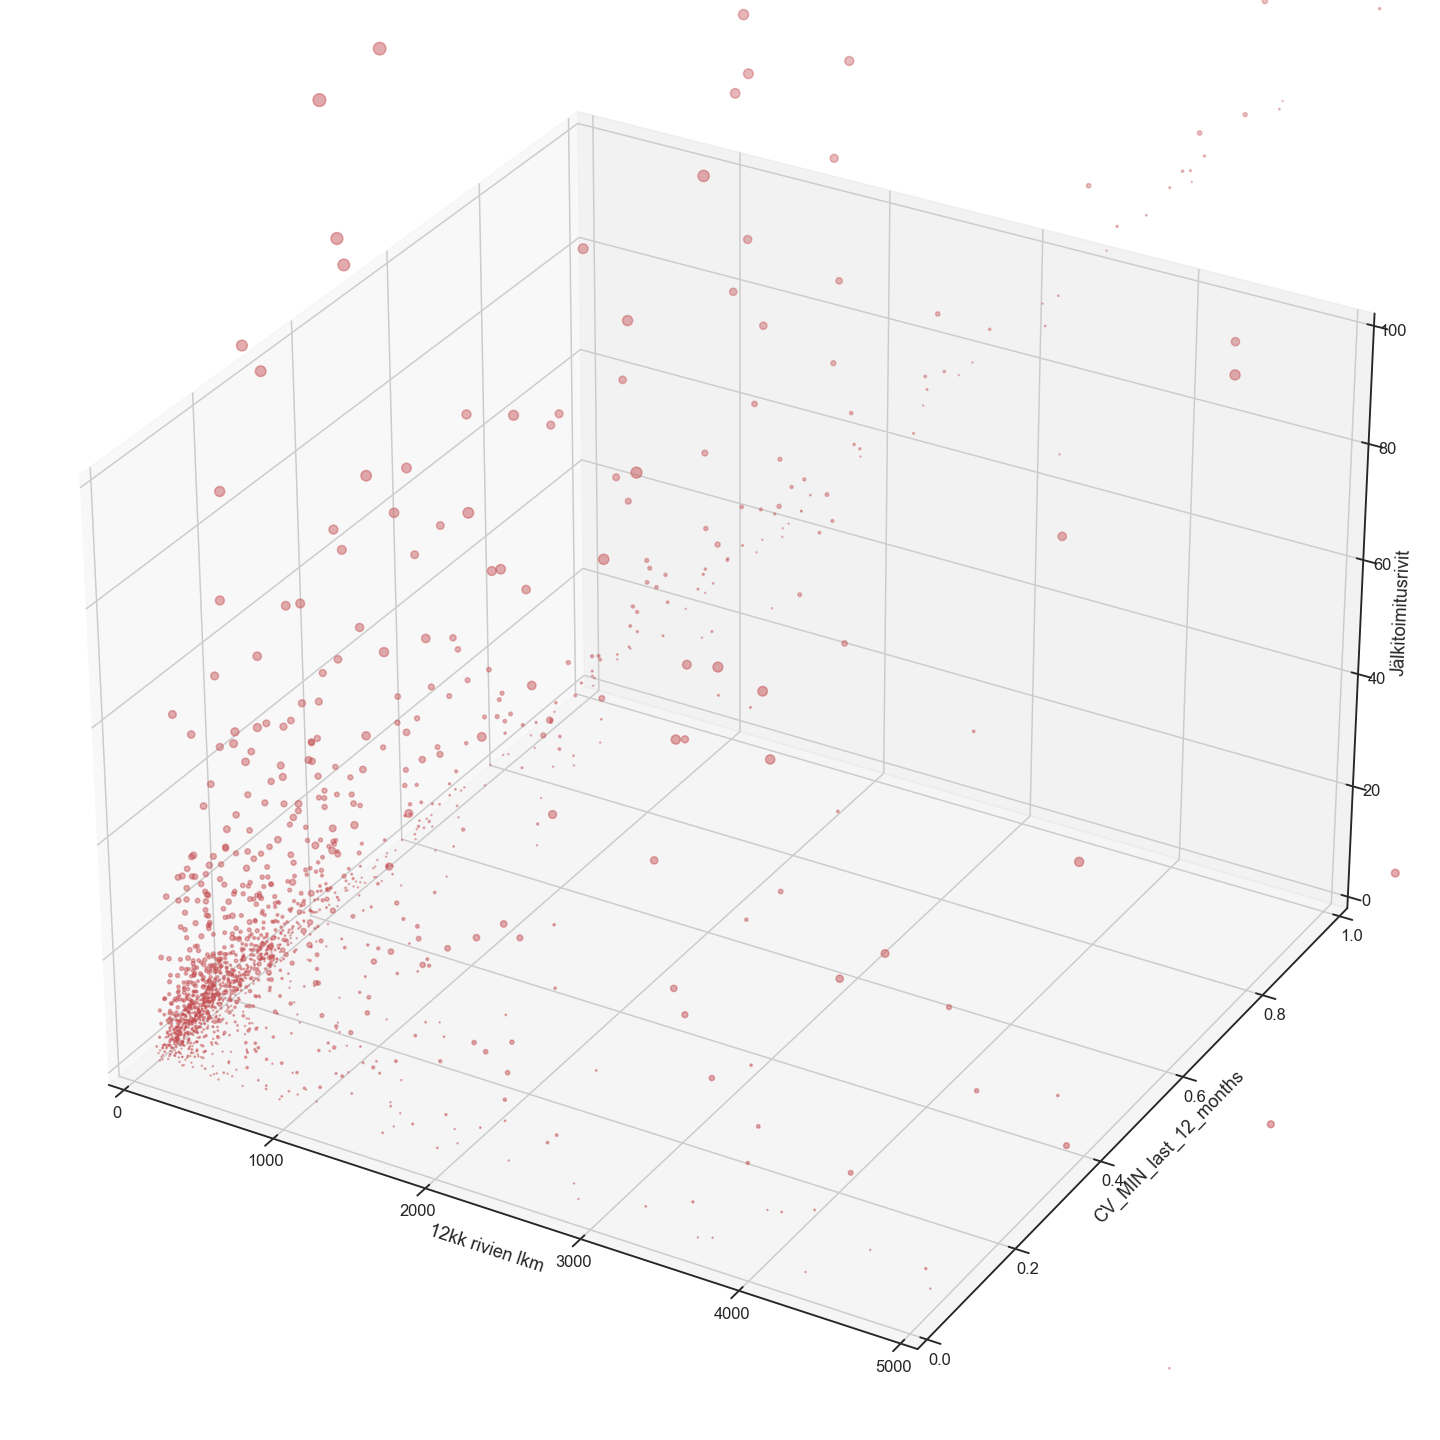

In [56]:
%matplotlib widget
sns.set(style="ticks", context="talk")
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig) # Method 1

ax.scatter(df_scatter_jälki['12kk rivien lkm'], df_scatter_jälki['CV_MIN_last_12_months'], df_scatter_jälki['Jälkitoimitusrivit'], s = df_scatter_jälki['Jälkitoimitusrivit'], c = 'r')

ax.set_xlabel('12kk rivien lkm')
ax.set_ylabel('CV_MIN_last_12_months')
ax.set_zlabel('Jälkitoimitusrivit')

ax.set_xlim(0,5000)
ax.set_ylim(0,1)
ax.set_zlim(0,100)


### Suhteellisen vaihtelun ja jälkitoimitusten suhde

No handles with labels found to put in legend.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
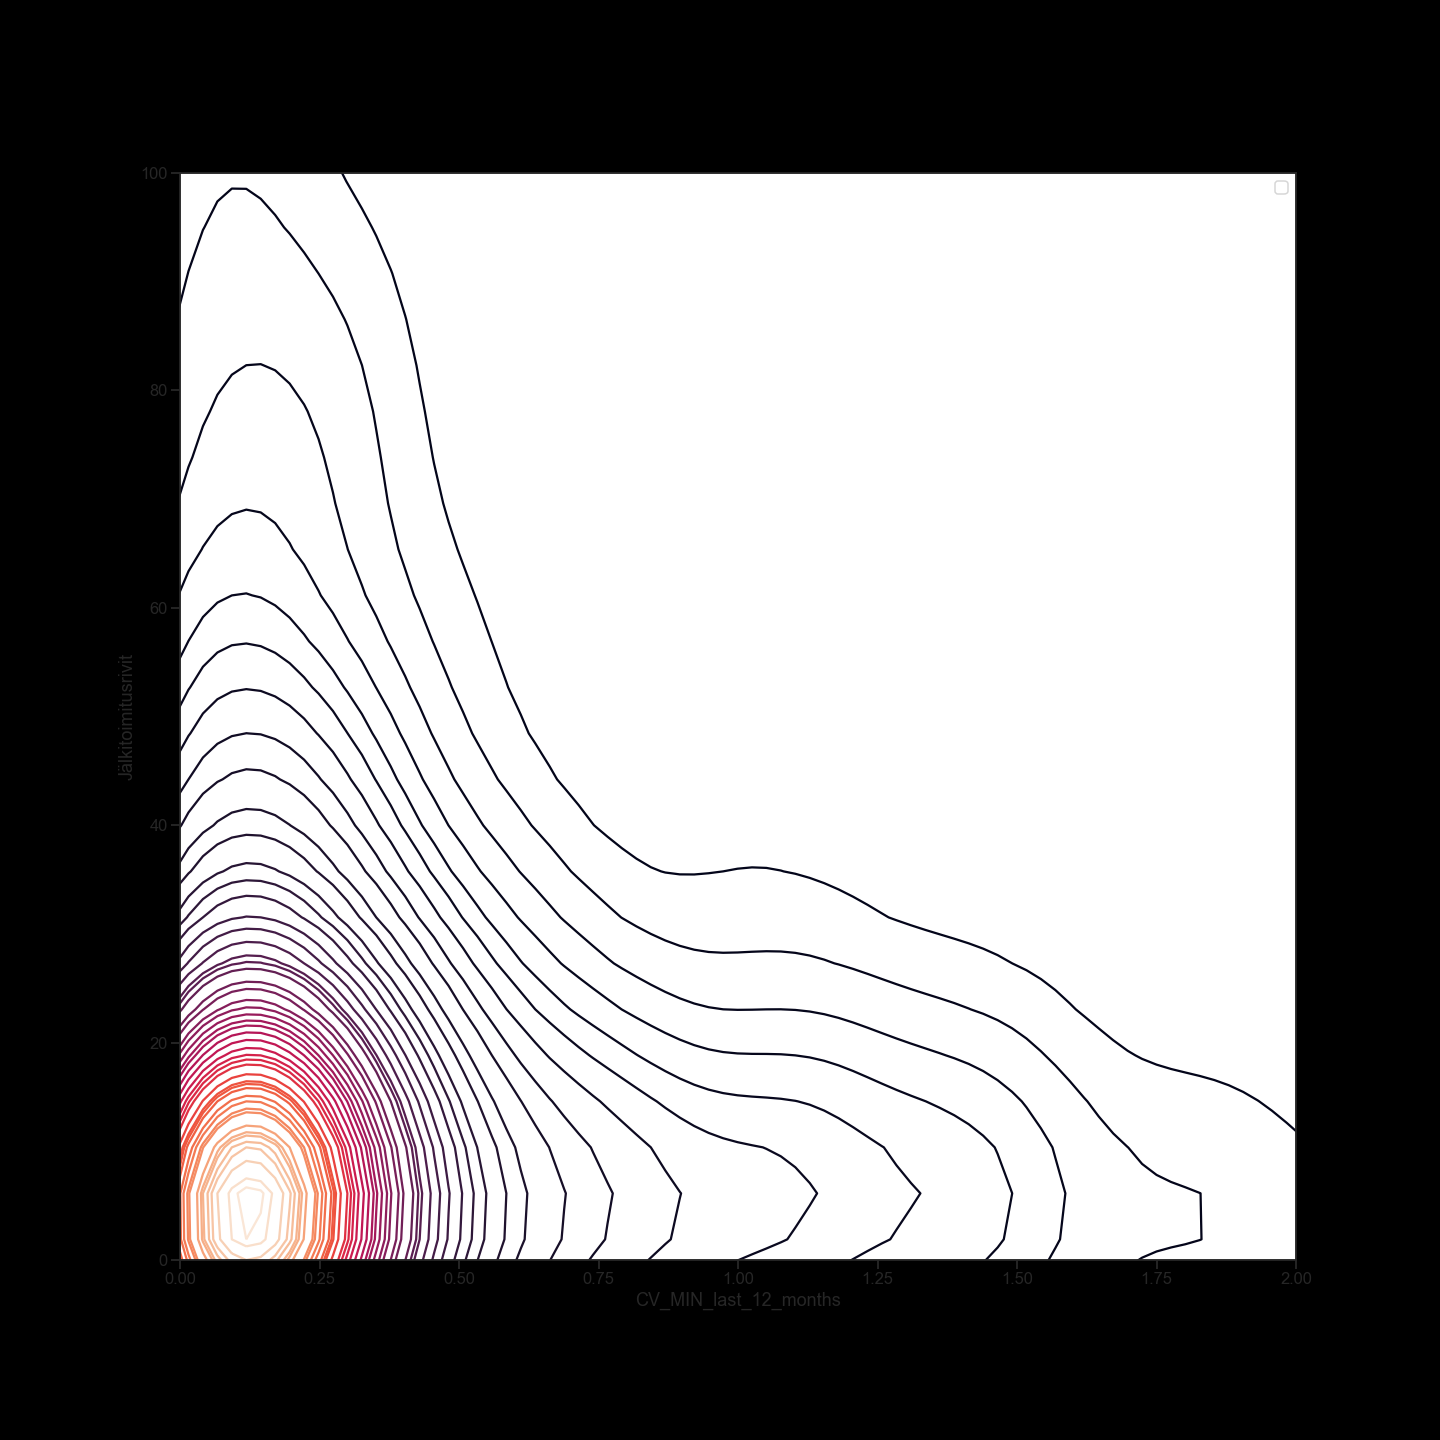

In [50]:
sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(20,20))

sns.kdeplot(x='CV_MIN_last_12_months', y='Jälkitoimitusrivit', data=df_scatter_jälki, levels = 50, fill=False, cmap='rocket')
ax.set_xlim(0,2)
ax.set_ylim(0,100)
ax.legend()